# 6. Selección de Modelos

In [1]:
import numpy as np

## Dataset

Definimos datos de lenguaje natural de juguete y vectorizamos el input usando bolsas de palabras.

In [2]:
training = [
    ('chinese beijing chinese', 'zh'),
    ('chinese chinese shangai', 'zh'),
    ('chinese macao', 'zh'),
    ('chinese beijing tokyo', 'zh'),
    ('chinese beijing osaka', 'zh'),
    ('tokyo japan chinese', 'ja'),
    ('tokyo japan osaka', 'ja'),
    ('osaka', 'ja'),
]

conjunto de entrenamiento original

In [3]:
X_docs = np.array([doc for doc, _ in training])
y = np.array([cls for _, cls in training])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X = vect.fit_transform(X_docs)

In [5]:
X

<8x7 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

## Validación Cruzada

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

### División K-Fold

Podemos usar [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para hacer cross-validation:

In [24]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=True, random_state=0)

for train_index, val_index in kf.split(X): 
    X_train, X_val = X[train_index], X[val_index] #particiones con un conj de entrenamiento y de validacion
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [0 1 3 4 5 7] VAL: [2 6] ['zh' 'ja']
TRAIN: [0 2 3 4 5 6] VAL: [1 7] ['zh' 'ja']
TRAIN: [1 2 4 5 6 7] VAL: [0 3] ['zh' 'zh']
TRAIN: [0 1 2 3 6 7] VAL: [4 5] ['zh' 'ja']


la division se hace en distintas particiones. teniammos 8 instancias de entrenamiento y le pido 4 particiones. por cada una de las particiones hay distintas instancias posibles. 

### División K-Fold Estratificada

Para que la división sea estratificada, usamos [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html):

In [27]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [0 1 3 6 7] VAL: [2 4 5] ['zh' 'zh' 'ja']
TRAIN: [1 2 4 5 7] VAL: [0 3 6] ['zh' 'zh' 'ja']
TRAIN: [0 2 3 4 5 6] VAL: [1 7] ['zh' 'ja']


## Búsqueda en Grilla (Grid Search)

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

forma de definir lo que se llama una grilla de parametros y dsp ver todas las diferentes posibilidades. Sirve para elegir los hiperparametros

### Grilla de Parámetros

In [8]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier??

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    ccp_alpha=0.0,
)
Source:        
class DecisionTreeClassifier(ClassifierMixin, BaseDecisionTree):
    """A decision tree classifier.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    criterion : {"gini", "entropy"}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "entropy" for the information gain.

    splitter : {"best", "random"}, default="best"
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the best split and "random" to choose
        the best random split.

In [28]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2], #profundidad 1 y 2 del arbol
}

Podemos listar todas las combinaciones para usarlas a mano con [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html):

In [29]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid): #distintas configuraciones recorriendo los parametros
    print(params)
    model = DecisionTreeClassifier(**params, random_state=0)
    #model.fit(...)
    #model.predict(...)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}


devuelve todas las conbinaciones posibles para cada una de las configuraciones. Voy a obtener un modelo para cada una de las conbinaciones posibles

### Grilla de Parámetros + Validación Cruzada

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) nos sirve para hacer validación cruzada sobre una grilla de parámetros. Sklearn se encarga de todo el proceso y nos devuelve una tabla de resultados y el mejor clasificador obtenido.

La búsqueda se puede configurar de varias maneras. Por defecto la validación cruzada es estratificada.

- [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter9)

In [31]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3) #uno le pasa el modelo, la grilla de parametros a recorrer, metrica de scoring y cross validation 
cv.fit(X, y);

el cross validation recorrio todas las combinaciones, configuraciones posibles.

cv=3 significa que son tres particiones

In [12]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
gini	1	| 0.50	0.14	3
gini	2	| 0.61	0.08	1
entropy	1	| 0.50	0.14	3
entropy	2	| 0.61	0.08	1


los rankeados mas altos son los mejores modelos en base al accurancy

In [13]:
import pandas as pd
df = pd.DataFrame(results)
df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]
#df

,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,gini,1,0.500000,0.136083,3
1,gini,2,0.611111,0.078567,1
2,entropy,1,0.500000,0.136083,3
3,entropy,2,0.611111,0.078567,1


In [32]:
best_model = cv.best_estimator_ #guarda el modelo final. el que mejor funciona

In [33]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 2}

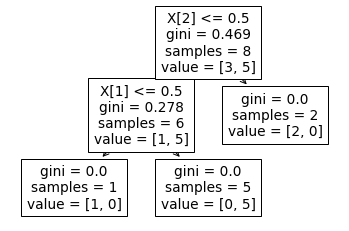

In [15]:
from sklearn.tree import plot_tree

plot_tree(best_model);

Tengo que ver si es verdadera o falsa la pregunta que se hace en el nodo. Este modelo esta entrenado con los 8 datos (samples 8) - en las hojas puedo ver que tengo en el value= 2 + 1 + 5 = 8 samples

cada fiture me dice si esta presente o no alguna de las palabras.

en la raiz x2 es el fiture 3 y me preg si esta o no esta la palabra japan

si vale cero o false me voy para la izquierda y si vale 1 o true para la derecha. y significa que habla sobre japon

en la rama de la izq se fija en fiture x1 si esta o no la palabra chinese. Si no esta va para la izq y si esta va para la derecha. 

gini= es entropia. queremos que sea lo mas chica posible. Si es cero, significa que tengo todas instancias de la misma clase. 

In [16]:
vect.get_feature_names()

['beijing', 'chinese', 'japan', 'macao', 'osaka', 'shangai', 'tokyo']

In [17]:
best_model.predict(vect.transform(['chinese japan']))

array(['ja'], dtype='<U2')

### Búsqueda Aleatoria

- [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

busqueda de parametros -> busqueda aleatoria: lo que uno hace es definir que parametros me interesa buscar, 

siempre usa como algoritmo de entrenamiento metodo de gradiente decreciente


In [18]:
from sklearn.linear_model import SGDClassifier
SGDClassifier??

Init signature:
SGDClassifier(
    loss='hinge',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    n_jobs=None,
    random_state=None,
    learning_rate='optimal',
    eta0=0.0,
    power_t=0.5,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    warm_start=False,
    average=False,
)
Source:        
class SGDClassifier(BaseSGDClassifier):
    """Linear classifiers (SVM, logistic regression, etc.) with SGD training.

    This estimator implements regularized linear models with stochastic
    gradient descent (SGD) learning: the gradient of the loss is estimated
    each sample at a time and the model is updated along the way with a
    decreasing strength schedule (aka learning rate). SGD allows minibatch
    (online/out-of-core) learning via the `partial_fit` method.
    For best results using the default lear

In [19]:
model = SGDClassifier(random_state=0)

In [34]:
from sklearn.utils.fixes import loguniform
from scipy import stats

param_dist = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
        #'preceptron',  # perceptron (not supported)
    ],
    'alpha': loguniform(1e-4, 1e2),  # de 0.0001 a 100.0 # loguniform: forma de samplear valores que tengan distinta magnitud
}

que distribucion quiero para cada uno de los parametros

Podemos muestrear mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [35]:
from sklearn.model_selection import ParameterSampler

for params in ParameterSampler(param_dist, 10, random_state=0): #10 configuraciones posibles
    print(params)
    model = SGDClassifier(**params, random_state=0)
    #model.fit(...)
    #model.predict(...)

{'alpha': 0.196282248134428, 'loss': 'log'}
{'alpha': 11.630395714480306, 'loss': 'log'}
{'alpha': 0.18590843630169634, 'loss': 'log'}
{'alpha': 0.5512926225087423, 'loss': 'hinge'}
{'alpha': 0.042220489831498266, 'loss': 'hinge'}
{'alpha': 0.0002189161813274828, 'loss': 'hinge'}
{'alpha': 0.01998246739232945, 'loss': 'hinge'}
{'alpha': 7.46470024356059, 'loss': 'hinge'}
{'alpha': 0.256016152500287, 'loss': 'log'}
{'alpha': 10.386580256500283, 'loss': 'hinge'}


### Búsqueda Aleatoria + Validación Cruzada

También podemos dejar que Sklearn se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):


In [36]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, random_state=0) #pruebo 10 configuraciones y le hace la cross validation
cv.fit(X, y);

In [23]:
import pandas as pd
results = cv.cv_results_
df = pd.DataFrame(results)
df[['param_loss', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_loss,param_alpha,mean_test_score,std_test_score,rank_test_score
0,log,0.196282,0.888889,0.157135,2
1,log,11.630396,0.888889,0.157135,2
2,log,0.185908,0.888889,0.157135,2
3,hinge,0.551293,0.888889,0.157135,2
4,hinge,0.04222,0.888889,0.157135,2
5,hinge,0.000219,0.888889,0.157135,2
6,hinge,0.019982,1.000000,0.000000,1
7,hinge,7.4647,0.888889,0.157135,2
8,log,0.256016,0.888889,0.157135,2
9,hinge,10.38658,0.888889,0.157135,2


In [37]:
cv.best_estimator_

SGDClassifier(alpha=0.01998246739232945, random_state=0)

In [38]:
cv.best_params_

{'alpha': 0.01998246739232945, 'loss': 'hinge'}

## Referencias


Scikit-learn:

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)